This notebook contains baseline model for personality prediction 
using MBTI dataset. 

The Myers Briggs Type Indicator (or MBTI for short) is a personality type system that divides everyone into 16 distinct personality types across 4 axis:
* Introversion (I) – Extroversion (E)
* Intuition (N) – Sensing (S)
* Thinking (T) – Feeling (F)
* Judging (J) – Perceiving (P)

In the dataset, there are 8600 rows of data. Each row contains a person's MBTI personality class and the last 50 things that he/she posted in PersonalityCafe Forum. 


In [3]:
# import libraries 
import json 
import numpy as np
seed = 123
np.random.seed(seed)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import learning_curve
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
from os.path import join

In [4]:
# define constants 
data_folder = "../dataset/"
raw_data_file = "mbti_1.csv"
punc_data_file = join(data_folder,"preprocessed_data_punc.json")
links_data_file = join(data_folder,"preprocessed_data_links.json")
letter_data_file = join(data_folder,"preprocessed_data_letters.json")
type_data_file = join(data_folder,"preprocessed_data_type.json")
prep_data_file = join(data_folder,"preprocessed_data_all.json")
none_data_file = join(data_folder,"preprocessed_data_none.json")

n_splits = 5 # number of splits for cross-validation
shuffle_flag = True 

scoring = {'acc': 'accuracy',
           'neg_log_loss': 'neg_log_loss',
           'f1_micro': 'f1_micro'}

In [5]:
# define functions 
def read_dataset(filepath):
    with open(filepath) as fp:
        return json.load(fp)


def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Prepare Data

In [7]:
def prepare_data(data_file, max_features= 5000, json_flag=False):
    """ for a given datafile reads the content and returns 
      posts and labels 
      @data_file: string, the path of the file 
      @json_flag: bool, True if given file is in json format
      @max_features: int, number of features in tf-idf
      Returns 
      @X_train_cnt: tf-idf vectors of training posts  
      @X_tes_cnt: tf-idf vectors of test posts
      @y_train: int, train labels 
      @y_test: int, test labels
    """
    if json_flag:
        dataset = read_dataset(data_file)
        posts = list(dataset['posts'])
        labels = list(dataset['types'])
    else:
        dataset = pd.read_csv(data_file)
        posts = list(dataset['posts'].values)
        labels = list(dataset['type'].values)
    print("The number of data %d " %(len(posts)))
    print("Example from dataset")
    print(posts[0][0:50]) 
    print("For type %s" %(labels[0]))
    posts = [p.lower() for p in posts]
    #return posts, labels 

    # train-test split 
    X = np.array(posts)
    y = np.array(labels)
    X_train, X_test, y_train, y_test = train_test_split(posts, labels, 
                                                    test_size=0.2, 
                                                    random_state=seed)
    print("Number of examples in train set %d " %(len(X_train)))
    print("Number of examples in test set %d " %(len(X_test)))

    # create a matrix of numbers to represent posts
    tfidf2 = CountVectorizer(ngram_range=(1, 1), 
                         stop_words='english',
                         lowercase = False, 
                         max_features = max_features)

    X_train_cnt = tfidf2.fit_transform(X_train)
    X_test_cnt = tfidf2.transform(X_test)
    return X_train_cnt, X_test_cnt, y_train, y_test

In [8]:
X_train_cnt, X_test_cnt, y_train,y_test = prepare_data(prep_data_file,json_flag=True)

The number of data 8675 
Example from dataset
  link link type type moment link sportscenter top
For type 8
Number of examples in train set 6940 
Number of examples in test set 1735 


## Naive Bayes

In [9]:
model = MultinomialNB()
kfolds = StratifiedKFold(n_splits=n_splits, shuffle=shuffle_flag, random_state=seed)

results_nb = cross_validate(model, X_train_cnt,y_train, cv=kfolds, 
                          scoring=scoring, n_jobs=-1)

In [10]:
print("CV Accuracy: {:0.4f} (+/- {:0.4f})".format(np.mean(results_nb['test_acc']),
                                                          np.std(results_nb['test_acc'])))

print("CV F1: {:0.4f} (+/- {:0.4f})".format(np.mean(results_nb['test_f1_micro']),
                                                          np.std(results_nb['test_f1_micro'])))

print("CV Logloss: {:0.4f} (+/- {:0.4f})".format(np.mean(-1*results_nb['test_neg_log_loss']),
                                                          np.std(-1*results_nb['test_neg_log_loss'])))

CV Accuracy: 0.3557 (+/- 0.0058)
CV F1: 0.3557 (+/- 0.0058)
CV Logloss: 9.1488 (+/- 0.2160)


Make prediction with the model on test data

In [11]:
# Make prediction with fit model
model.fit(X_train_cnt,y_train)
y_preds = model.predict(X_test_cnt)
accuracy = balanced_accuracy_score(y_test,y_preds)
print("Accuracy for test data {:0.4f}".format(accuracy))

Accuracy for test data 0.2313


## Logistic Regression

In [32]:
model_lr = LogisticRegression(solver = 'sag',
                              multi_class='multinomial',
                              max_iter=400,
                              class_weight="balanced", 
                              C=0.005)
kfolds = StratifiedKFold(n_splits=n_splits, shuffle=shuffle_flag, random_state=seed)

results_logrec = cross_validate(model_lr, X_train_cnt,y_train, cv=kfolds, 
                          scoring=scoring, n_jobs=-1)

In [33]:
print("CV Accuracy: {:0.4f} (+/- {:0.4f})".format(np.mean(results_logrec['test_acc']),
                                                          np.std(results_logrec['test_acc'])))

print("CV F1: {:0.4f} (+/- {:0.4f})".format(np.mean(results_logrec['test_f1_micro']),
                                                          np.std(results_logrec['test_f1_micro'])))

print("CV Logloss: {:0.4f} (+/- {:0.4f})".format(np.mean(-1*results_logrec['test_neg_log_loss']),
                                                          np.std(-1*results_logrec['test_neg_log_loss'])))

CV Accuracy: 0.3367 (+/- 0.0125)
CV F1: 0.3367 (+/- 0.0125)
CV Logloss: 2.0574 (+/- 0.0265)


In [35]:
# Make prediction with fit model
model_lr.fit(X_train_cnt,y_train)
y_preds = model_lr.predict(X_test_cnt)
accuracy = balanced_accuracy_score(y_test,y_preds)
print("Accuracy for test data {:0.4f}".format(accuracy))

Accuracy for test data 0.2548


# Test Models for all preprocessed datasets

In [12]:
data_files = {"all":prep_data_file,
              "punc":punc_data_file,
              "links":links_data_file,
              "letters":letter_data_file,
              "type":type_data_file,
             "none":none_data_file}
for k,v in data_files.items():
    print("Modelling for %s " %(k))
    X_train_cnt, X_test_cnt, y_train, y_test = prepare_data(data_files[k],json_flag=True)
    # do models
    #1 - NB
    model = MultinomialNB()
    print("Training Naive Bayes for %s " %(k))
    model.fit(X_train_cnt,y_train)
    y_preds = model.predict(X_test_cnt)
    accuracy = balanced_accuracy_score(y_test,y_preds)
    print("Accuracy of NB for test data {:0.4f}".format(accuracy))

    #2-LogRec
    print("Training LogRec for %s " %(k))
    model_lr = LogisticRegression(solver = 'sag',
                              multi_class='multinomial',
                              max_iter=400,
                              class_weight="balanced", 
                              C=0.005)
    model_lr.fit(X_train_cnt,y_train)
    y_preds = model_lr.predict(X_test_cnt)
    accuracy = balanced_accuracy_score(y_test,y_preds)
    print("Accuracy of LogRec for test data {:0.4f}".format(accuracy))

Modelling for all 
The number of data 8675 
Example from dataset
  link link type type moment link sportscenter top
For type 8
Number of examples in train set 6940 
Number of examples in test set 1735 
Training Naive Bayes for all 
Accuracy of NB for test data 0.2313
Training LogRec for all 
Accuracy of LogRec for test data 0.2548
Modelling for punc 
The number of data 8675 
Example from dataset
 'http://www.youtube.com/watch?v=qsxhcwe3krw http:
For type 8
Number of examples in train set 6940 
Number of examples in test set 1735 
Training Naive Bayes for punc 
Accuracy of NB for test data 0.4184
Training LogRec for punc 
Accuracy of LogRec for test data 0.5889
Modelling for links 
The number of data 8675 
Example from dataset
 'link link enfp intj moment  link  sportscenter t
For type 8
Number of examples in train set 6940 
Number of examples in test set 1735 
Training Naive Bayes for links 
Accuracy of NB for test data 0.4258
Training LogRec for links 
Accuracy of LogRec for test data

## KNN Classifier

In [ ]:
model = KNeighborsClassifier(n_neighbors = 3)

kfolds = StratifiedKFold(n_splits=n_splits, shuffle=shuffle_flag, random_state=seed)

results_knn = cross_validate(model, X_train_cnt,y_train, cv=kfolds, 
                          scoring=scoring, n_jobs=-1)

In [ ]:
print("CV Accuracy: {:0.4f} (+/- {:0.4f})".format(np.mean(results_knn['test_acc']),
                                                          np.std(results_knn['test_acc'])))

print("CV F1: {:0.4f} (+/- {:0.4f})".format(np.mean(results_knn['test_f1_micro']),
                                                          np.std(results_knn['test_f1_micro'])))

print("CV Logloss: {:0.4f} (+/- {:0.4f})".format(np.mean(-1*results_knn['test_neg_log_loss']),
                                                          np.std(-1*results_knn['test_neg_log_loss'])))

CV Accuracy: 0.1569 (+/- 0.0033)
CV F1: 0.1569 (+/- 0.0033)
CV Logloss: 22.1406 (+/- 0.1179)


In [ ]:
# Make prediction with fit model
model.fit(X_train_cnt,y_train)
y_preds = model.predict(X_test_cnt)
accuracy = balanced_accuracy_score(y_test,y_preds)
print("Accuracy for test data {:0.4f}".format(accuracy))

Accuracy for test data 0.0667


## Plot Confusion Matrix for Logistic Regression

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_preds)
classes = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP', 'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ'] 
lab_encoder = LabelEncoder().fit(classes)
classes=lab_encoder.inverse_transform(range(16))
title = "Confusion Matrix"

Text(0.5, 47.975689975440226, 'Predicted label')

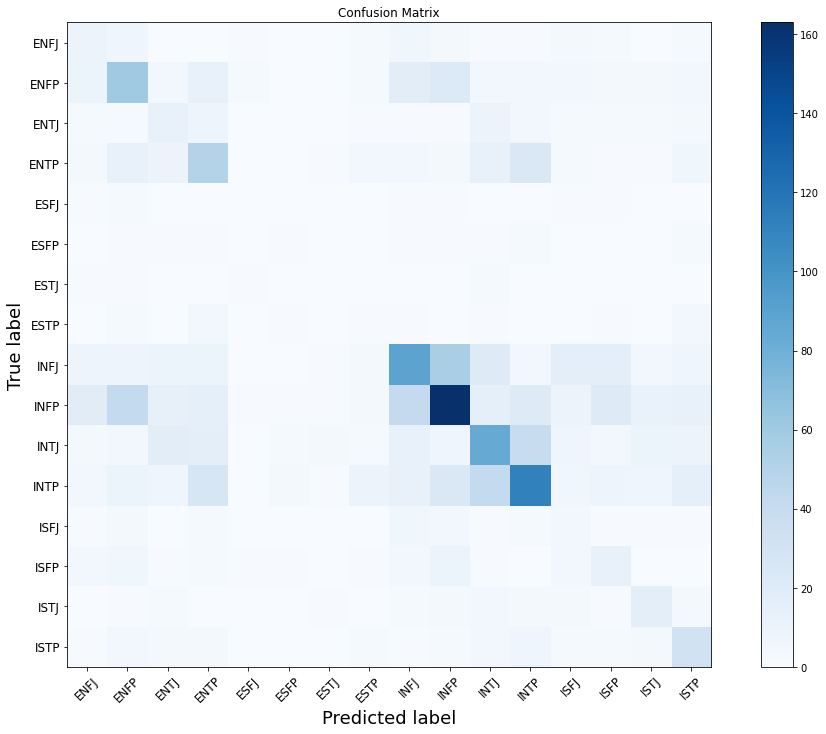

In [ ]:
plt.figure(figsize=(14,10))
plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
plt.yticks(tick_marks, classes, fontsize=12)

plt.tight_layout()
plt.ylabel('True label',fontsize=18)
plt.xlabel('Predicted label',fontsize=18)